In [114]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [115]:
!pip install keras

# Setting

In [116]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 64
EPOCHS = 30

print(ROOT_PATH)

/aiffel/aiffel


# Dataset

In [117]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [118]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [119]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [120]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [121]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [122]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [123]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [124]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [125]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [126]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [127]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [128]:


# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     return image,label

# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     # augment 적용 부분이 배치처리 함수에 추가되었습니다.
#     ds = ds.map(
#             augment,       # augment 함수 적용
#             num_parallel_calls=2
#         )
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)

#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

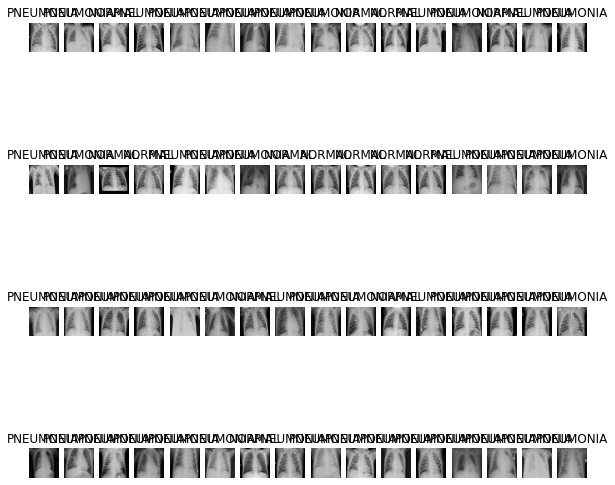

In [129]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())



In [130]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [131]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='tanh'),#relu-->tanh
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

# like VGG, --> Resnet 으로 설계해볼 것 !!! 

In [132]:
def build_model(dropout=True):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.1),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.1),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(256, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [133]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


# GPU 가속 



In [134]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=METRICS
    )

# Image Data Augmentation 



In [135]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range = 20,#몸이 좀 틀어진경우(각도?자세?) 
                            horizontal_flip = True,
                            featurewise_std_normalization=True,
                            samplewise_std_normalization=True)
model.fit_generator(datagen.flow(image_batch, label_batch,batch_size=64),steps_per_epoch =len(image_batch)//64,  epochs = 30)

Epoch 1/30
1/1 [==============================] - 4s 4s/step - loss: 0.9238 - accuracy: 0.5312 - precision: 0.7941 - recall: 0.5400
Epoch 2/30
1/1 [==============================] - 1s 590ms/step - loss: 0.6821 - accuracy: 0.6562 - precision: 0.8889 - recall: 0.6400
Epoch 3/30
1/1 [==============================] - 1s 628ms/step - loss: 0.6122 - accuracy: 0.7500 - precision: 0.9722 - recall: 0.7000
Epoch 4/30
1/1 [==============================] - 1s 615ms/step - loss: 0.6895 - accuracy: 0.7500 - precision: 0.9474 - recall: 0.7200
Epoch 5/30
1/1 [==============================] - 1s 592ms/step - loss: 0.6249 - accuracy: 0.6875 - precision: 0.9688 - recall: 0.6200
Epoch 6/30
1/1 [==============================] - 1s 598ms/step - loss: 0.6535 - accuracy: 0.6875 - precision: 0.9412 - recall: 0.6400
Epoch 7/30
1/1 [==============================] - 1s 655ms/step - loss: 0.6535 - accuracy: 0.7188 - precision: 0.9706 - recall: 0.6600
Epoch 8/30
1/1 [==============================] - 1s 622ms

In [136]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
65/65 [==============================] - 58s 772ms/step - loss: 0.2969 - accuracy: 0.8421 - precision: 0.9792 - recall: 0.8050 - val_loss: 0.5808 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/30
65/65 [==============================] - 49s 755ms/step - loss: 0.2091 - accuracy: 0.8976 - precision: 0.9894 - recall: 0.8718 - val_loss: 0.6800 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/30
65/65 [==============================] - 50s 776ms/step - loss: 0.1723 - accuracy: 0.9207 - precision: 0.9869 - recall: 0.9051 - val_loss: 1.1689 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 4/30
65/65 [==============================] - 51s 787ms/step - loss: 0.1478 - accuracy: 0.9303 - precision: 0.9903 - recall: 0.9157 - val_loss: 1.6128 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/30
65/65 [==============================] - 53s 821ms/step - loss: 0.1337 - accuracy: 0.9401

# lr scheduler

In [137]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.7, monitor='val_loss', patience=1, verbose=2, min_lr=1e-8)

In [138]:
with tf.device('/GPU:0'):
    model_no_drop_lr = build_model(dropout=False)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_no_drop_lr.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [139]:
with tf.device('/GPU:0'):
    history_no_drop_lr = model_no_drop_lr.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[lr_scheduler],
    )

Epoch 1/30
65/65 [==============================] - 58s 748ms/step - loss: 0.3727 - accuracy: 0.8091 - precision: 0.9784 - recall: 0.7606 - val_loss: 0.6379 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 2/30
65/65 [==============================] - 46s 717ms/step - loss: 0.2262 - accuracy: 0.8810 - precision: 0.9876 - recall: 0.8507 - val_loss: 0.5831 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 3/30
65/65 [==============================] - 47s 728ms/step - loss: 0.1875 - accuracy: 0.9075 - precision: 0.9888 - recall: 0.8854 - val_loss: 0.8242 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
Epoch 4/30
65/65 [==============================] - 48s 748ms/step - loss: 0.1420 - accuracy: 0.9339 - precision: 0.9934 - recall: 0.9174 - val_loss: 1.1605 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000

Epoch 00004: Reduc

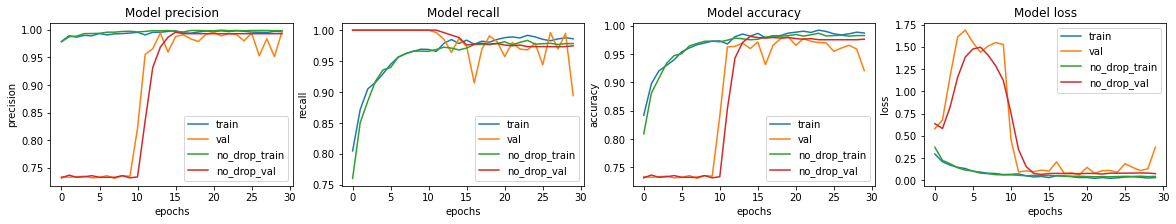

In [140]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].plot(history_no_drop_lr.history[met])
    ax[i].plot(history_no_drop_lr.history['val_' + met])
    
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val','no_drop_train', 'no_drop_val'])

In [141]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 5s 455ms/step - loss: 0.6495 - accuracy: 0.8590 - precision: 0.8463 - recall: 0.9462
Loss: 0.6494559049606323,
Accuracy: 0.8589743375778198,
Precision: 0.8463302850723267,
Recall: 0.9461538195610046


In [142]:
loss, acc, prec, rec = model_no_drop_lr.evaluate(test_ds)

10/10 [==============================] - 4s 424ms/step - loss: 1.0877 - accuracy: 0.7740 - precision: 0.7371 - recall: 0.9923


# 회고
### TPU 로 돌리려고 해보았으나, 자료형 (텐서형태로 입력되어야 함) 및 데이터 로드 과정에서 문제가 있었으며, 따라서 GPU 로 돌리게 되었다
### ImageDataGenerator 를 적절히 이용하여 model.fit 이전에 model.fit 을 시켰다. 그 결과 augmentation 이 잘 되었고 정확도가 올라가게 되었다. 그런데 어떤 기능은 쓰면 더 내려가는 경우가 있으므로
### 깊은 이해가 필요하다.
### False Positive(FP): 분류자가 부정 클래스를 긍정으로 잘못 예측한 예측의 수를 나타냅니다. 이것이 중요하므로, (TP+TN)/(TP+TN+FP+FN) 공식 인 accuracy 가 중요하다.
### drop 대신 learning rate scheduler 를 이용하였다 그 결과 정확도가 상승하였다.
### 점점 수렴하는 것을 lr scheduler 의 효과로 볼 수 있다.


